In [6]:
%load_ext autoreload
%autoreload 2
from torchvision import transforms
from src.dataset import AlzheimerDataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from src.model import *
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import gc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Perform data augmentation and take a look at the dimensions of the data

In [7]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.CenterCrop((190))])
train_dataset = AlzheimerDataset("./dataset/train", transform=transform)
test_dataset = AlzheimerDataset("./dataset/test", transform=transform)

print("Training data lenght: ", len(train_dataset))
print("Test data lenght: ", len(test_dataset))
print("Dimensions of an image: ", train_dataset[0]["image"].shape)

Training data lenght:  5121
Test data lenght:  1279
Dimensions of an image:  torch.Size([1, 190, 190])


Take a look at the data, classes

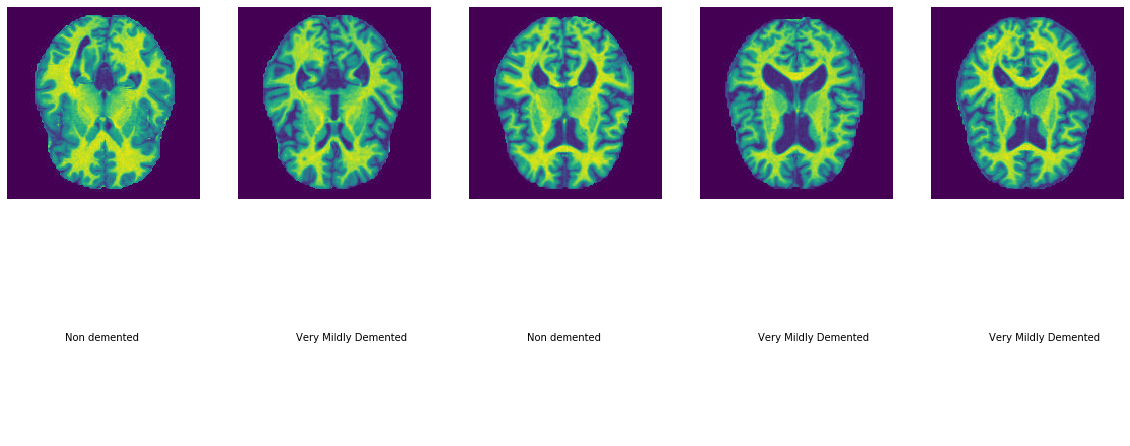

In [8]:
classes = sorted(["Non demented", "Very Mildly Demented", "Mildly Demented", "ModerateDemented"])

num_images = 5
fig, ax = plt.subplots(2, num_images, figsize=(20, 8))
for i in range(num_images):
    index = np.random.randint(0, len(train_dataset))
    ax[0][i].imshow(train_dataset[index]["image"].squeeze(0).numpy())
    ax[1][i].text(0.3, 0.5, classes[train_dataset[index]["label"]])
    
    ax[0][i].axis("off")
    ax[1][i].axis("off")


Instantiate the actual modell which will be trained, and move it to the cuda device

In [9]:
model = AdaptiveResidualClassifier().to("cuda")
#model.load_state_dict(torch.load("./model.p"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

The training function

In [10]:
def train(dataloader, model, loss_fn, optim):
    model.train()
    run_loss = 0.0
    for i, data in enumerate(dataloader):
        optim.zero_grad()
        image, label = data["image"].cuda(), data["label"].cuda()
        pred = model(image)
        loss = loss_fn(pred, label)
        loss.backward()
        optim.step()
        run_loss += loss.detach().item()
       
    return run_loss/len(dataloader)

Let's see if the model is strong enough to be overfitted to one data entry

In [11]:
#Overfits the model to one image
def overfit_one(image, model, loss_fn, optim):
    model.train()
    optim.zero_grad()
    img, label = image["image"].cuda(), image["label"].cuda()
    pred = model(img)
    loss = loss_fn(pred, label)
    loss.backward()
    optim.step()
   
    return loss.item()

Optimizer and loss function

In [12]:
#Optimizer
optim = torch.optim.RMSprop(model.parameters(), lr = 1e-3)

In [13]:
#Loss
loss_fn = nn.CrossEntropyLoss()

The actual training process, many hyperparameters

In [14]:
#model.load_state_dict(torch.load("./model2.p"))
loss = 1000.
best_loss = 10
count = 0
epochs = 10

for epoch in tqdm(range(epochs)):
    
    print(loss)
    
    loss = train(train_loader, model, loss_fn, optim)
    
    #early stopping
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), "./model2.p")
        count = 0
    
    elif loss > best_loss:
        count +=1
    
    if count > 5:
        break
    
    clear_output()
print(loss)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

1000.0


  0%|                                                                                           | 0/10 [00:01<?, ?it/s]


RuntimeError: running_mean should contain 256 elements not 128

Acurracy:  50.03909304143862 %


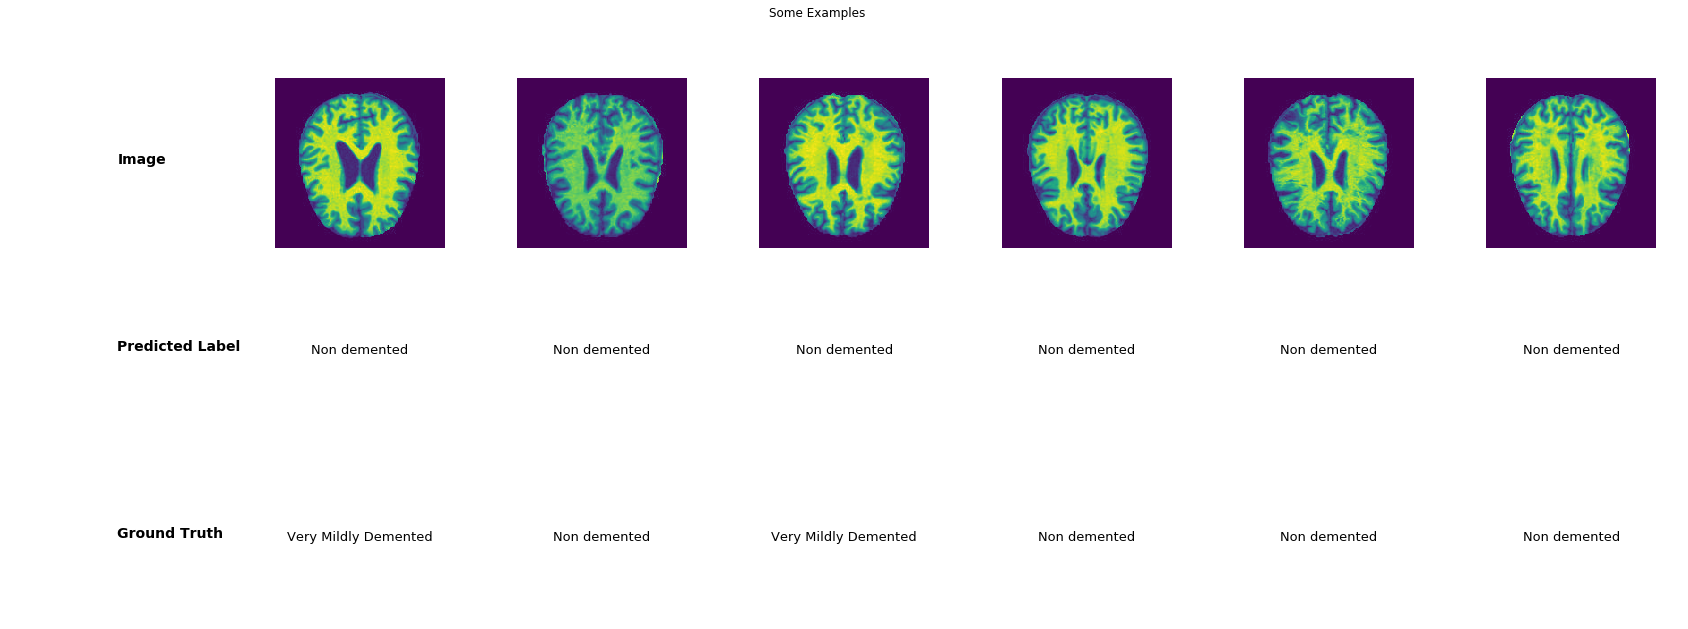

In [11]:
#Testing the model
model.load_state_dict(torch.load("./model2.p"))
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)
test_model(test_loader, model)
print("Acurracy: ", test_acurracy(test_loader, model)*100, "%")

In [14]:
torch.save(model.state_dict(), "./model2.p")